<img width="50" src="https://carbonplan-assets.s3.amazonaws.com/monogram/dark-small.png" style="margin-left:0px;margin-top:20px"/>

# Project Fire Risk

_by Jeremy Freeman (CarbonPlan), November 28, 2020_

This notebook shows a couple different ways of extracting the fire risk for a forest carbon project based on historical records.


In [2]:
import fsspec
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gp
import regionmask as rm

In [62]:
%matplotlib inline
from showit import image
import matplotlib.pyplot as plt

First we load the monthly MTBS data

In [5]:
mapper = fsspec.get_mapper("/Users/freeman/workdir/carbonplan-data/processed/mtbs/conus/4000m/monthly.zarr")
da = xr.open_zarr(mapper)["monthly"]
da.load();

We'll also load "supersections" which we'll use for computing regional statistics

In [434]:
regions = gp.read_file("/Users/freeman/workdir/carbonplan-data/raw/ecoregions/supersections.geojson")

And we'll compute masks from these regions

In [30]:
masks = rm.mask_3D_geopandas(regions, da)

Now we'll demo two examples of aggregating within regions to extract historical fire statistics.

In [51]:
from scipy.stats import binom
def integrated_risk(p):
    return (1 - binom.cdf(0, 100, p)) * 100

## Querying a project based on ecoregion

First we find the ecoregion a project belongs to

In [510]:
from shapely.geometry import Point
p = Point(-121.183861, 42.672889)

In [511]:
ecoregion = [i for i in regions.index if regions.geometry[i].contains(p)][0]

Get integrated fire risk

In [512]:
integrated_risk(da.where(masks[ecoregion]).mean(['x', 'y']).groupby('time.year').sum().sel(
    year=slice('2001','2018')).mean())

19.379535239496427

Plot burn area over time

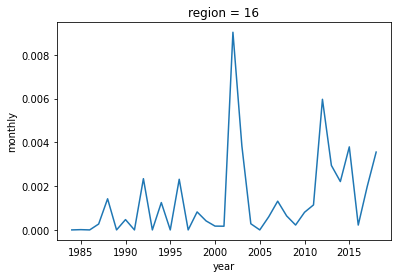

In [514]:
da.where(masks[ecoregion]).mean(['x', 'y']).groupby('time.year').sum().sel(
    year=slice('1984','2018')).plot()

## Querying a project based on location

In this version we define a disc with fixed radius at the center of a location and integrate over that

In [534]:
center = [-121.183861, 42.672889]

In [535]:
lat = da['lat']
lon = da['lon']
dist = (lon - center[0]) **2 + (lat - center[1]) **2
mask = dist < 0.5

In [536]:
integrated_risk(da.where(mask).mean(['x', 'y']).groupby('time.year').sum().sel(
    year=slice('2001','2018')).mean())

14.52819075434576

## Querying a project based on the shapefile

Finally, we can use a shapefile for a project and integrate over that area

In [537]:
region = gp.read_file("CAR1314.json")

In [539]:
mask = rm.mask_3D_geopandas(region1.simplify(0.002).buffer(0.005), da)[0]

<ipython-input-539-865bf4a8584f>:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mask = rm.mask_3D_geopandas(region1.simplify(0.002).buffer(0.005), da)[0]


In [540]:
integrated_risk(da.where(mask).mean(['x', 'y']).groupby('time.year').sum().sel(
    year=slice('2001','2018')).mean())

24.02069413504445

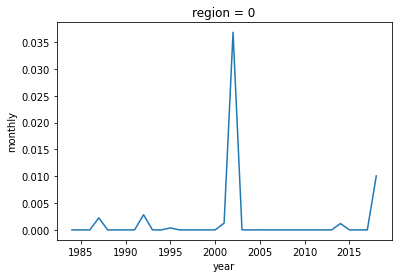

In [541]:
da.where(mask).mean(['x', 'y']).groupby('time.year').sum().plot()